In [7]:
import sys
sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import umap
import torch
from mpi4py import MPI
import hdbscan
import pyvista as pv
from sklearn.preprocessing import StandardScaler


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Reading data

In [10]:
# 1) File path
fname = "./data/v6/po_premix0.f00010"
gname = "./data/v6/po_premix0.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= True,
    compute_vel_hessian= False,
    compute_reaction_rates= True,
    cantera_inputs = ["BurkeH2.yaml", None, 0.3, 300, 1e05]
)
print(df.keys())
df.to_csv(f"data.csv", index=False)

2025-11-18 12:03:54,959 - Mesh - INFO - Initializing empty Mesh object.
2025-11-18 12:03:54,960 - Field - INFO - Initializing empty Field object
2025-11-18 12:03:54,961 - pynekread - INFO - Reading file: ./data/v6/po_premix0.f00001
2025-11-18 12:03:54,997 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-18 12:03:54,998 - Mesh - INFO - Initializing common attributes.
2025-11-18 12:03:54,999 - Mesh - INFO - Getting vertices
2025-11-18 12:03:55,004 - Mesh - INFO - Getting edge centers
2025-11-18 12:03:55,069 - Mesh - INFO - Facet centers not available for 2D
2025-11-18 12:03:55,070 - Mesh - INFO - Mesh object initialized.
2025-11-18 12:03:55,070 - Mesh - INFO - Mesh data is of type: float64
2025-11-18 12:03:55,070 - Mesh - INFO - Elapsed time: 0.07371750002494082s
2025-11-18 12:03:55,071 - pynekread - INFO - Reading field data
2025-11-18 12:03:55,071 - pynekread - INFO - Overwriting fld object
2025-11-18 12:03:55,808 - pynekread - INFO - File read
2025-11-18 12:03:55,

## Temperature plot

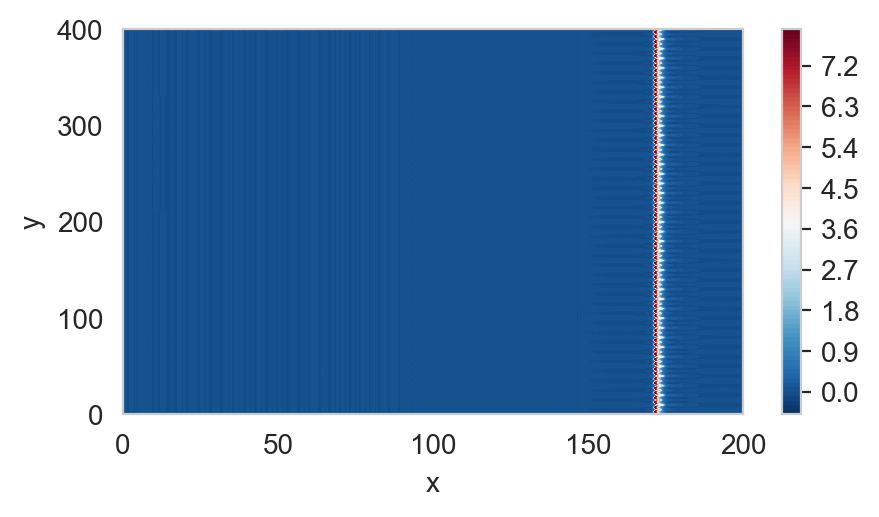

In [11]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(ds.msh.x.flatten(), ds.msh.y.flatten() , df["dudx"], levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

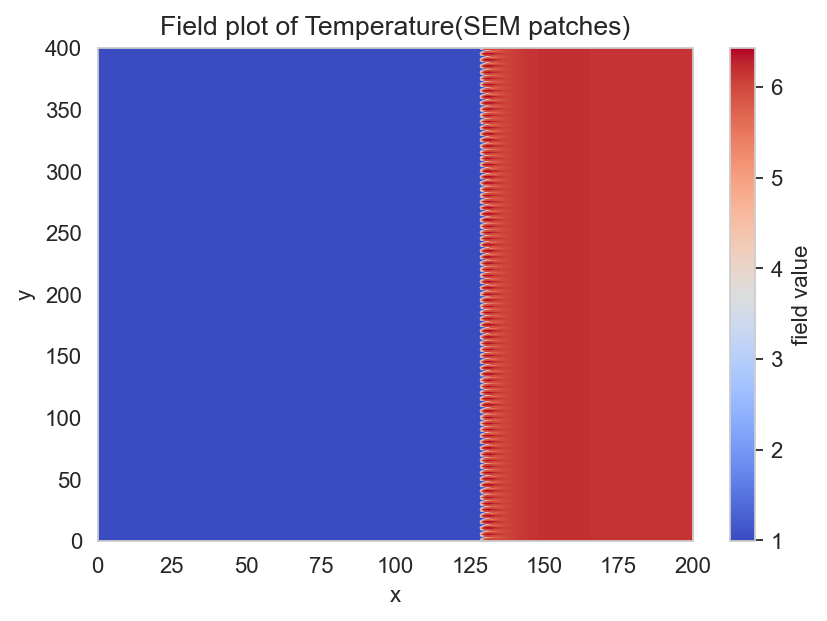

In [11]:
Plot2D.plot_field(ds.msh, ds.t,plot_name="Temperature", mode="sem", cmap="coolwarm")

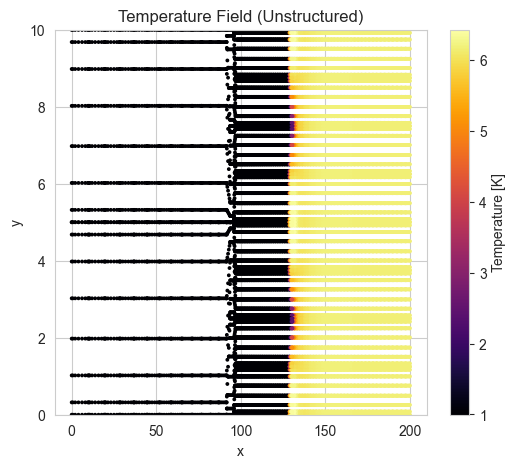

In [12]:
plt.figure(figsize=(6, 5))
plt.scatter(ds.x, ds.y, c=df["T"], cmap="inferno", s=3)
plt.colorbar(label="Temperature [K]")
plt.xlabel("x")
plt.ylim((0,10))
plt.ylabel("y")
plt.title("Temperature Field (Unstructured)")
plt.show()

## Pre-processing

In [15]:
# Select meaningful physical variables
# features = ['u', 'v', 'T', 'H2',
#        'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
#        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
#        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
#        'flow_velocity_tangential', 'tangential_strain_rate',
#        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
#        'vorticity']
features = [
    'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
       'omega_HO2', 'omega_H2O2', 'omega_N2'
]
# Scale dataset
X = StandardScaler().fit_transform(df[features])

# Set flame displacement speed as the colourmap
colourmap = X[:, 0]

## UMAP Dimensionality Reduction

In [16]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=20, n_components=2)
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar()
plt.show()

KeyboardInterrupt: 

## Clustering with HDBSCAN

In [11]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size= int(0.05 * len(X)),     #smallest "real" cluster (heuristic: ~0.5–2% of n)
    min_samples= 50, #int(0.02 * len(X)),          # sensitivity to noise (heuristic: ~dimensionality or 5–30)
    metric='euclidean',
    cluster_selection_method='eom',           # use 'leaf' for more/smaller clusters
    prediction_data=True                      # enables assigning new points later
).fit(X_embedded)

labels = clusterer.labels_                    # -1 means noise
proba  = clusterer.probabilities_             # per-point cluster confidence [0,1]
outlier_scores = clusterer.outlier_scores_    # higher => more outlier-like


unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

KeyboardInterrupt



## Mutual Information

In [13]:
from sklearn.feature_selection import mutual_info_regression
mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))

cluster_labels = sorted(set(labels) - {-1})   # exclude noise

mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:   # skip tiny clusters
        continue
    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)
    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)
    mi_cluster[cluster] = df_new


for cluster, df_new in mi_cluster.items():
    top = df_new.head(5)
    plt.figure(figsize=(5,3))
    plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
    plt.xlabel("Mutual Information (sum over dims)")
    plt.title(f"Cluster {cluster} — Top correlated features")
    plt.tight_layout()
    plt.show()

ValueError: All arrays must be of the same length

## Plotting

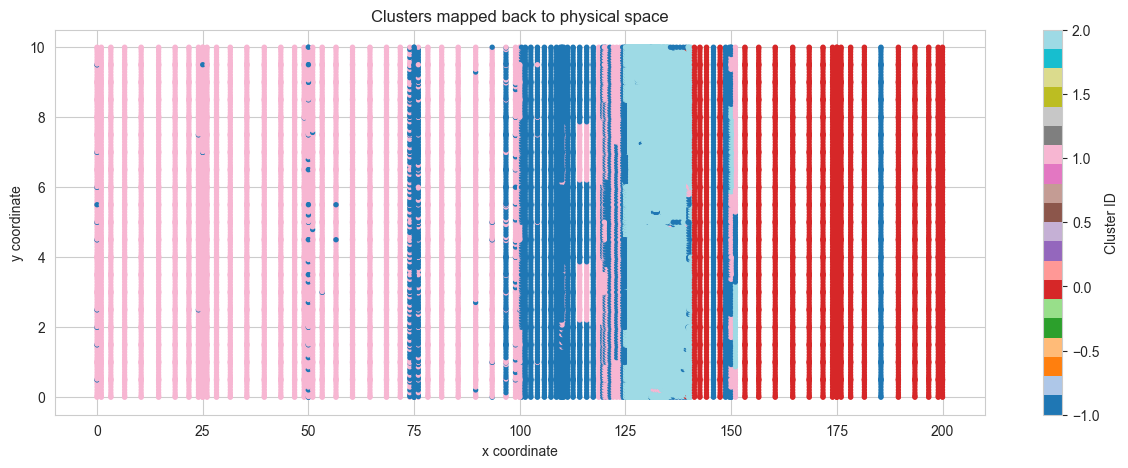

                u             v         T            H2        O2       H2O  \
cluster                                                                       
-1       1.872194  1.817574e-03  1.673094  9.524861e-03  0.213808  0.018419   
 0       5.875828  1.060633e-12  4.769041  7.185004e-08  0.138611  0.103136   
 1       1.181538 -7.276706e-05  1.140576  1.117121e-02  0.226781  0.003846   
 2       3.518429 -2.111810e-04  2.903079  4.723332e-03  0.183645  0.052844   

                    H             O        OH           HO2  ...  \
cluster                                                      ...   
-1       6.130647e-08  3.567243e-06  0.000025  1.093146e-07  ...   
 0       9.946951e-10  9.336737e-07  0.000054  1.066137e-07  ...   
 1       5.892215e-09  5.859056e-07  0.000005  2.236752e-08  ...   
 2       8.034803e-06  1.967621e-04  0.000413  2.721324e-05  ...   

         stretch_rate  disp_speed_density_weighted  abs_flame_prop_vel_normal  \
cluster                            

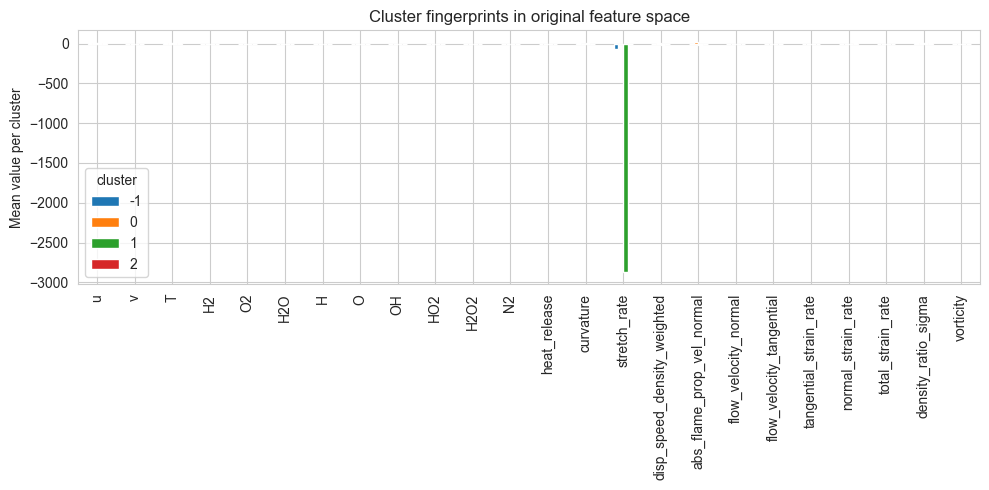

In [38]:

# --- Map clusters back to the original space ---
plt.figure(figsize=(15,5))
plt.scatter(
    ds.x, ds.y,
    c=labels, cmap='tab20', s=8, alpha=1
)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Clusters mapped back to physical space")
plt.colorbar(label="Cluster ID")
plt.show()

# --- Attach cluster labels to the original DataFrame ---
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

# --- Compute physical statistics per cluster ---
cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()
print(cluster_means.head())

# --- Plot cluster fingerprints ---
cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()